In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import strym
from strym import strymread
from strym import strymmap
import numpy as np

In [2]:
toyota_dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
folder = '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_07_08/'
toyota = "2020-07-08-15-15-54_2T3MWRFVXLW056972"
toyota_can_file = folder + toyota + "_CAN_Messages.csv"
r_toyota = strymread(csvfile=toyota_can_file, dbcfile=toyota_dbcfile)


In [3]:
lead_dist = r_toyota.get_ts(msg=869,signal="LEAD_DISTANCE")
lead_dist_l = lead_dist[(lead_dist['Time'] - lead_dist['Time'].iloc[0] >= 511)]
lead_dist_l_chunks = strymread.create_chunks(lead_dist_l, plot = True)

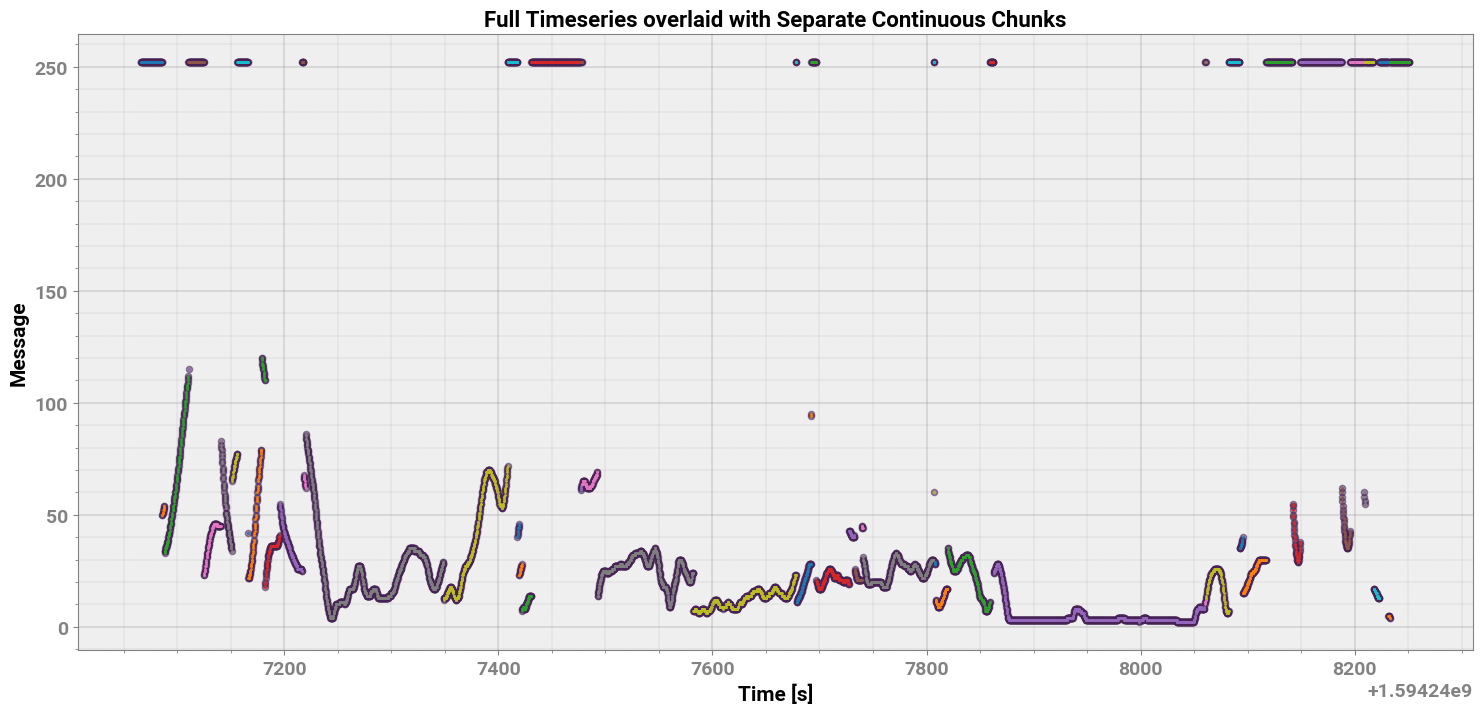

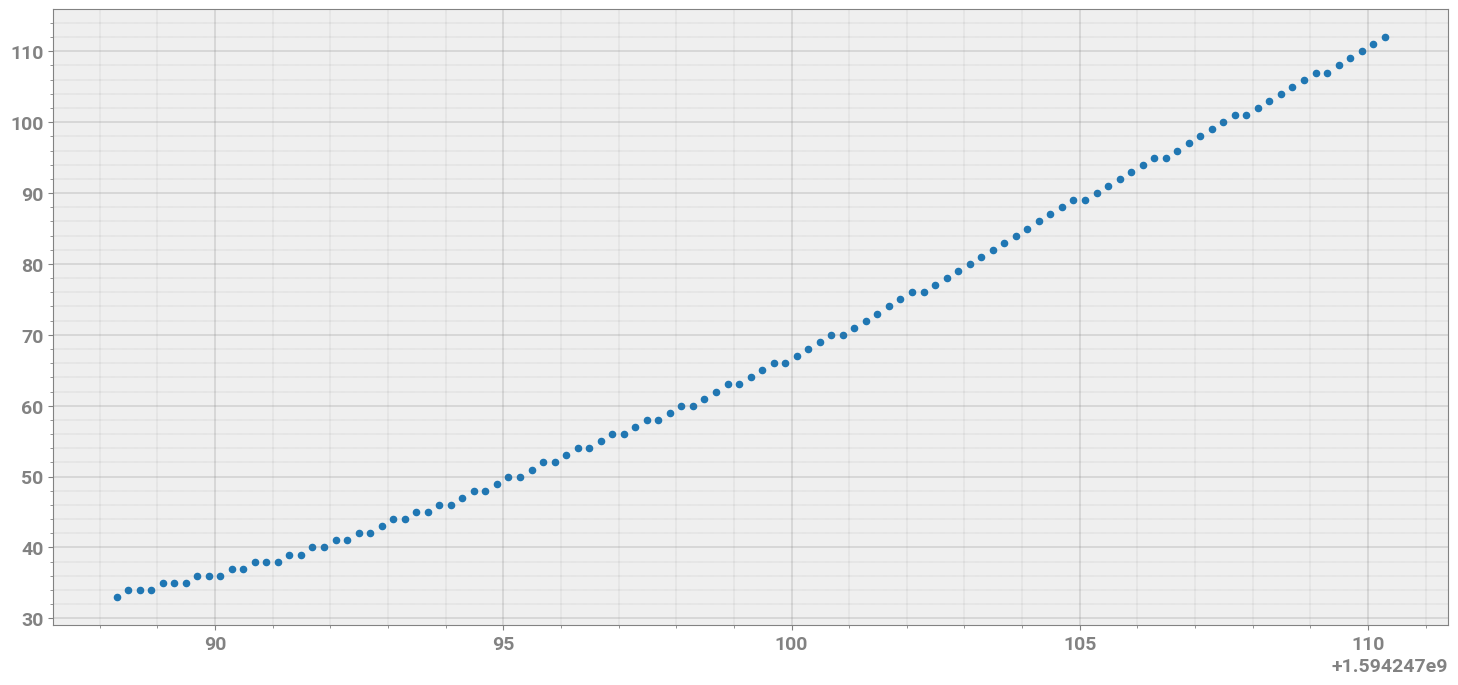

In [42]:
fig, ax = strym.create_fig(num_of_subplots=1)
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[0], s= 20, marker = 'o')
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[1], s= 20, marker = 'o')
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[2], s= 20, marker = 'o')
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[3], s= 20, marker = 'o')
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[4], s= 20, marker = 'o')
ax[0].scatter(x = 'Time', y = 'Message', data = lead_dist_l_chunks[5], s= 20, marker = 'o')

plt.show()

In [124]:
time_original = lead_dist_l_chunks[2]['Time'].values
time = (time_original - time_original[0])/(time_original[-1] - time_original[0])
message_original = lead_dist_l_chunks[2]['Message'].values
message = (message_original  - message_original[0])/(message_original[-1] - message_original[0])

In [150]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")
model.summary()
# Training
model.fit( time, message, epochs=1000, verbose=True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_84 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_85 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_86 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_87 (Dense)             (None, 1)               

In [169]:
newtimepoints_scaled = np.linspace(time[0] - (time[1] - time[0]),time[-1], 10000)
y_predicted_scaled = model.predict(newtimepoints_scaled)

newtimepoints = newtimepoints_scaled*(time_original[-1] - time_original[0]) + time_original[0]
y_predicted = y_predicted_scaled*(message_original[-1] - message_original[0]) + message_original[0]

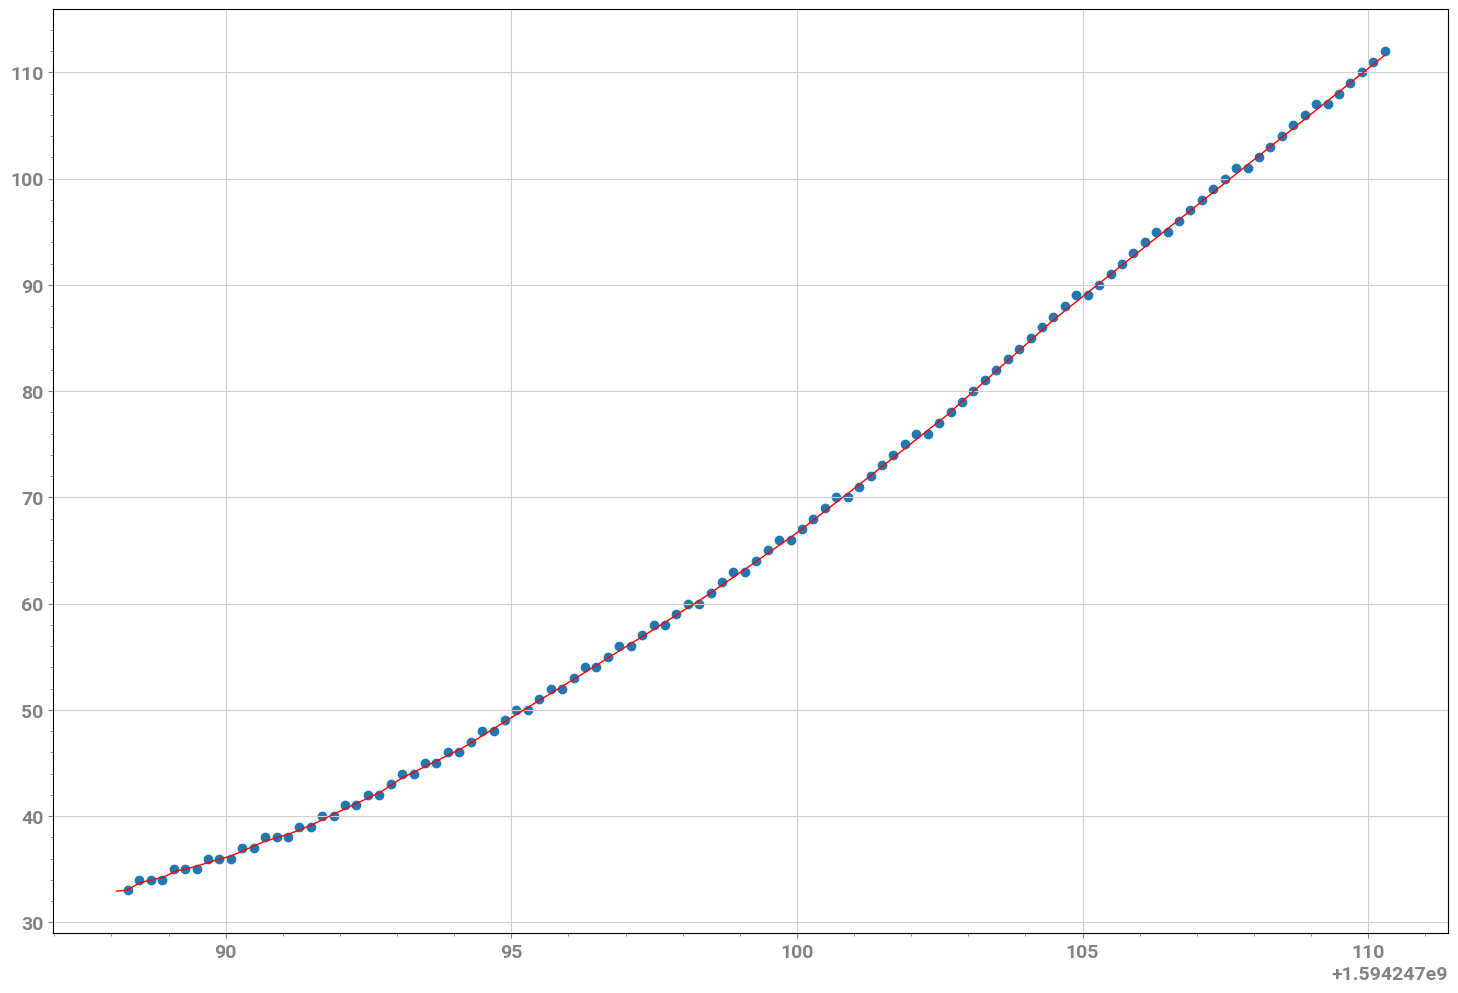

In [170]:

# Display the result
plt.scatter(time_original, message_original)
plt.plot(newtimepoints, y_predicted, 'r', linewidth=1)
plt.grid()
plt.show()

In [207]:
df = pd.DataFrame()
df['Time'] = newtimepoints
df['Message'] = y_predicted

df_new = strym.differentiate(df)
df['diff'] = df['Message'].diff()/df['Time'].diff()
df['diff'].iloc[0] = 0.0
df

,Time,Message,diff
0,1.594247e+09,32.940735,0.000000
1,1.594247e+09,32.941631,0.403737
2,1.594247e+09,32.942524,0.402019
3,1.594247e+09,32.943420,0.403780
4,1.594247e+09,32.944313,0.402019
...,...,...,...
9995,1.594247e+09,111.568703,4.291635
9996,1.594247e+09,111.578262,4.305380
9997,1.594247e+09,111.587791,4.292096
9998,1.594247e+09,111.597328,4.295071


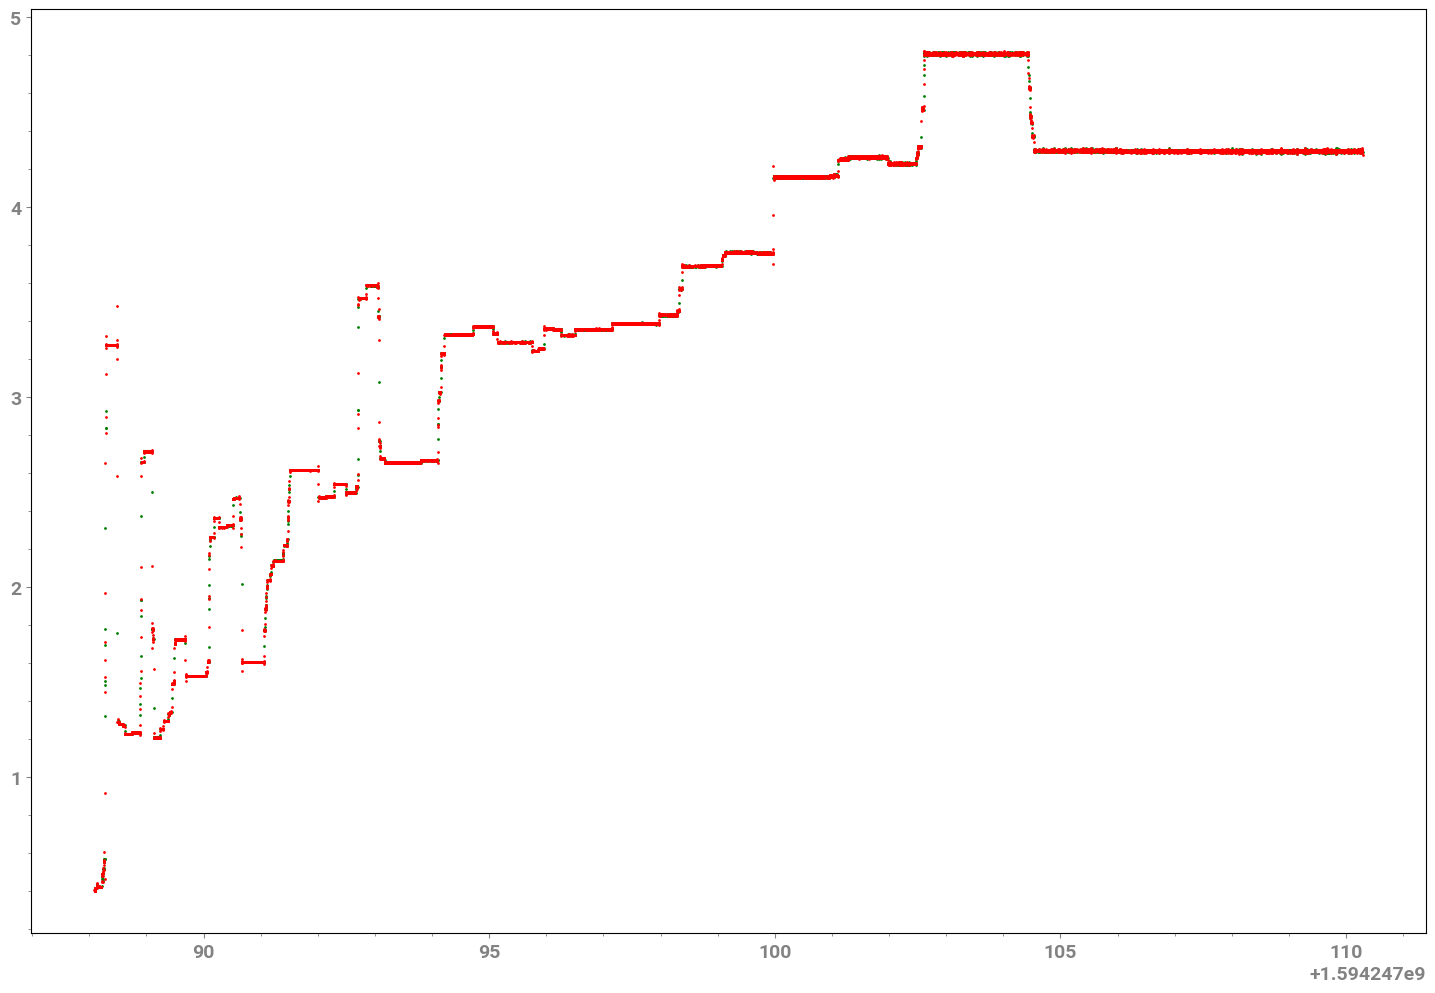

In [172]:
plt.scatter(df['Time'], df['diff'], s = 1, c="green")
plt.scatter(df_new['Time'], df_new['Message'], s = 1, c="red")

In [223]:
def ml_differentiate(df, verbose = False, dense_time_points = True):
    """
    Autoencoder based denosing followed by differentiation.
    Reference: https://lucidar.me/en/neural-networks/curve-fitting-nonlinear-regression/
    
    
    """
    # Check the monotonicity of the time in df
    collect_indices = []
    for i in range(0, len(df['Time'].values)-1):
        if df['Time'].values[i] == df['Time'].values[i+1]:
            collect_indices.append(df.index.values[i+1])
    df = df.drop(collect_indices)
    assert(np.all(np.diff(df['Time'].values) > 0.0)), ('Timestamps are not unique')
    
    
    time_original = df['Time'].values
    
    if time_original[-1] != time_original[0]:
        time = (time_original - time_original[0])/(time_original[-1] - time_original[0])
    else:
        time = time_original
    message_original = df['Message'].values    
    
    if message_original[-1] != message_original[0]:
        message = (message_original  - message_original[0])/(message_original[-1] - message_original[0])
    else:
        message = message_original
    
    import tensorflow as tf
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
    model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")
    
    if verbose:
        model.summary()
    # Training
    model.fit( time, message, epochs=1000, verbose=verbose)
    
    
    newtimepoints_scaled = np.linspace(time[0],time[-1], 10000)
    y_predicted_scaled = model.predict(newtimepoints_scaled)

    newtimepoints = newtimepoints_scaled*(time_original[-1] - time_original[0]) + time_original[0]
    y_predicted = y_predicted_scaled*(message_original[-1] - message_original[0]) + message_original[0]
    
    if dense_time_points:
        newtimepoints_scaled = np.linspace(time[0],time[-1], df.shape[0]*50)
    else:
        newtimepoints_scaled = time
    y_predicted_scaled = model.predict(newtimepoints_scaled)

    newtimepoints = newtimepoints_scaled*(time_original[-1] - time_original[0]) + time_original[0]
    y_predicted = y_predicted_scaled*(message_original[-1] - message_original[0]) + message_original[0]
    
    df_new = pd.DataFrame()
    df_new['Time'] = newtimepoints
    df_new['Message'] = y_predicted
    
    collect_indices = []
    for i in range(0, len(df_new['Time'].values)-1):
        if df_new['Time'].values[i] == df_new['Time'].values[i+1]:
            collect_indices.append(df_new.index.values[i+1])
    df_new = df_new.drop(collect_indices)
    
    assert(np.all(np.diff(df_new['Time'].values) > 0.0)), ('Timestamps are not unique')
    
    df_new['diff'] = df_new['Message'].diff()/df_new['Time'].diff()
    df_new.at[0,'diff']=0.0
    df_new.drop(columns=['Message'], inplace=True)
    df_new.rename(columns={"diff": "Message"}, inplace = True)

    return df_new

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


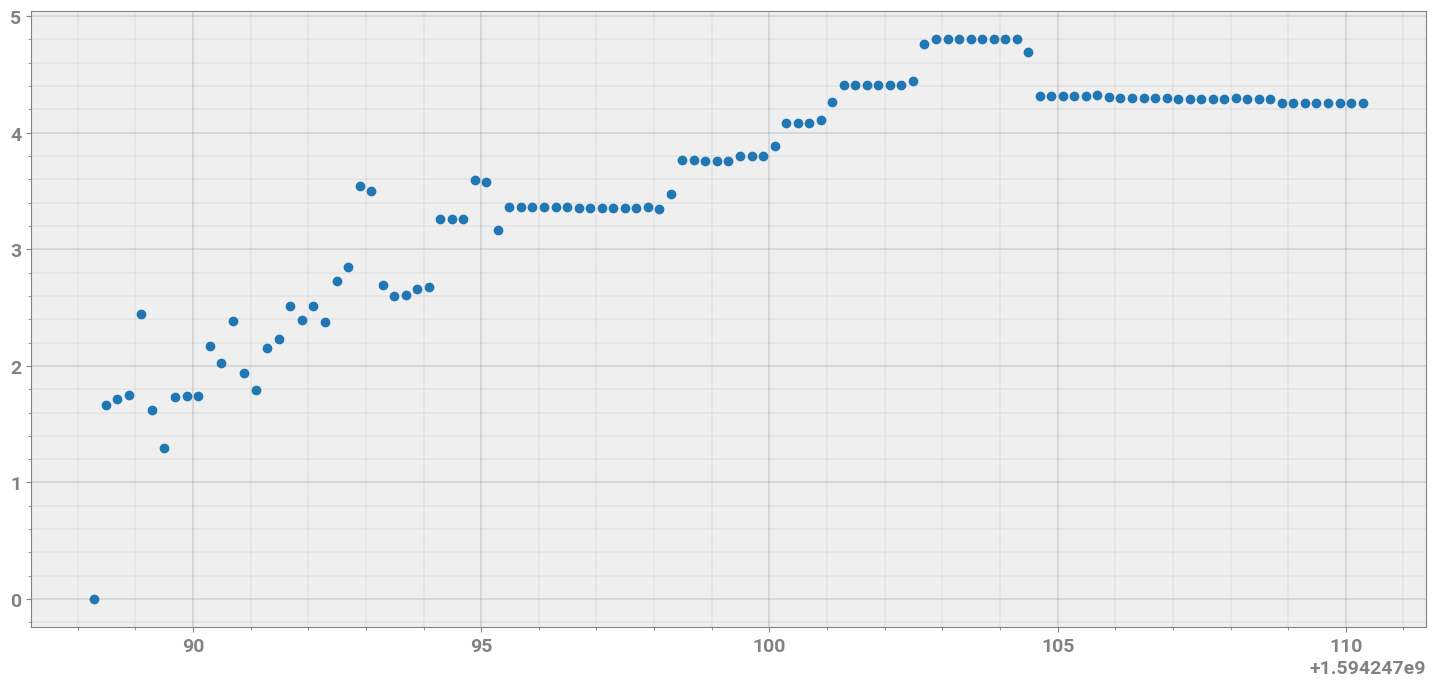

In [193]:
dn2 = ml_differentiate(lead_dist_l_chunks[2], dense_time_points=False)
fig, ax = strym.create_fig(1)
ax[0].scatter(x  = 'Time', y = 'Message', data = dn2)
plt.show()

In [202]:
dflist = []
for m in lead_dist_l_chunks:
    lp = ml_differentiate(m, dense_time_points=False)
    dflist.append(lp)

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


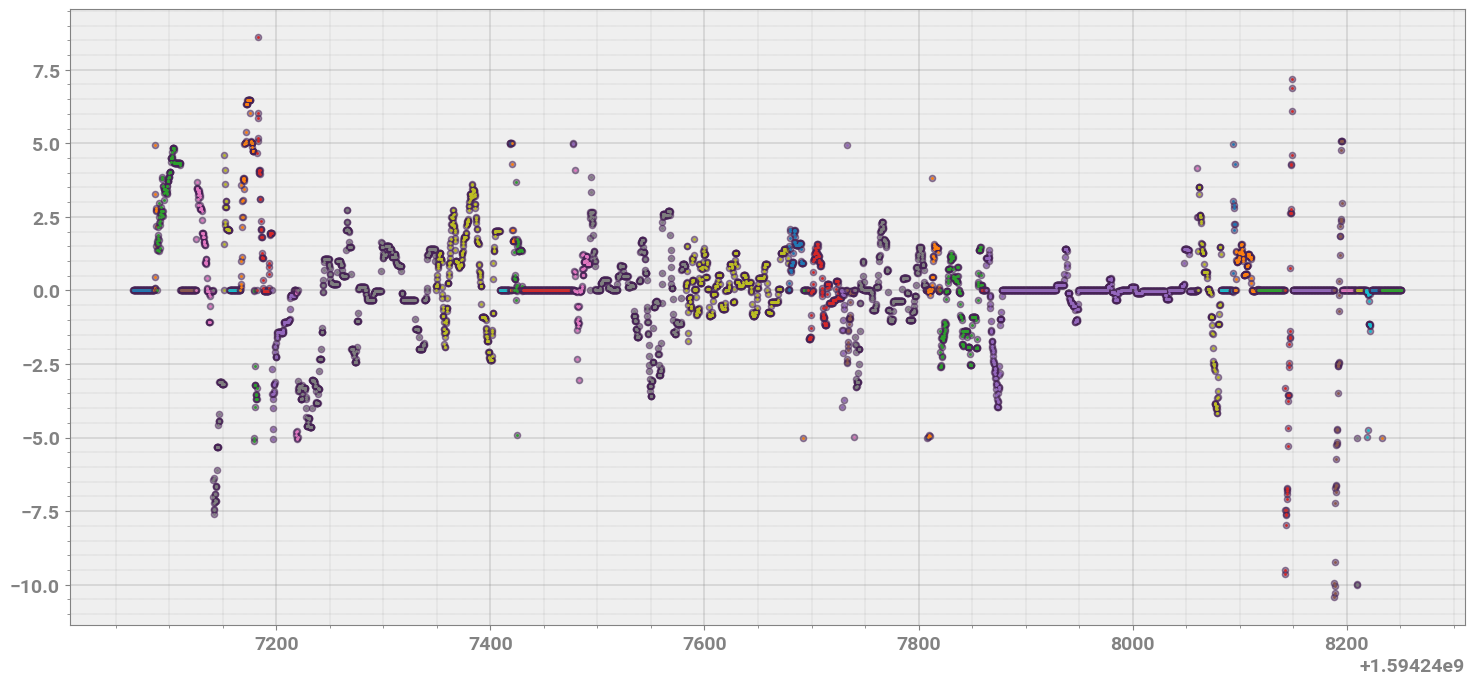

In [212]:
fig, ax = strym.create_fig(1)
for po in dflist:
    ax[0].scatter(x = 'Time', y  = "Message", data = po, s = 20,marker = 'o', alpha = 0.5, color = "#462255")
    ax[0].scatter(x = 'Time', y  = "Message", data = po, s = 1)

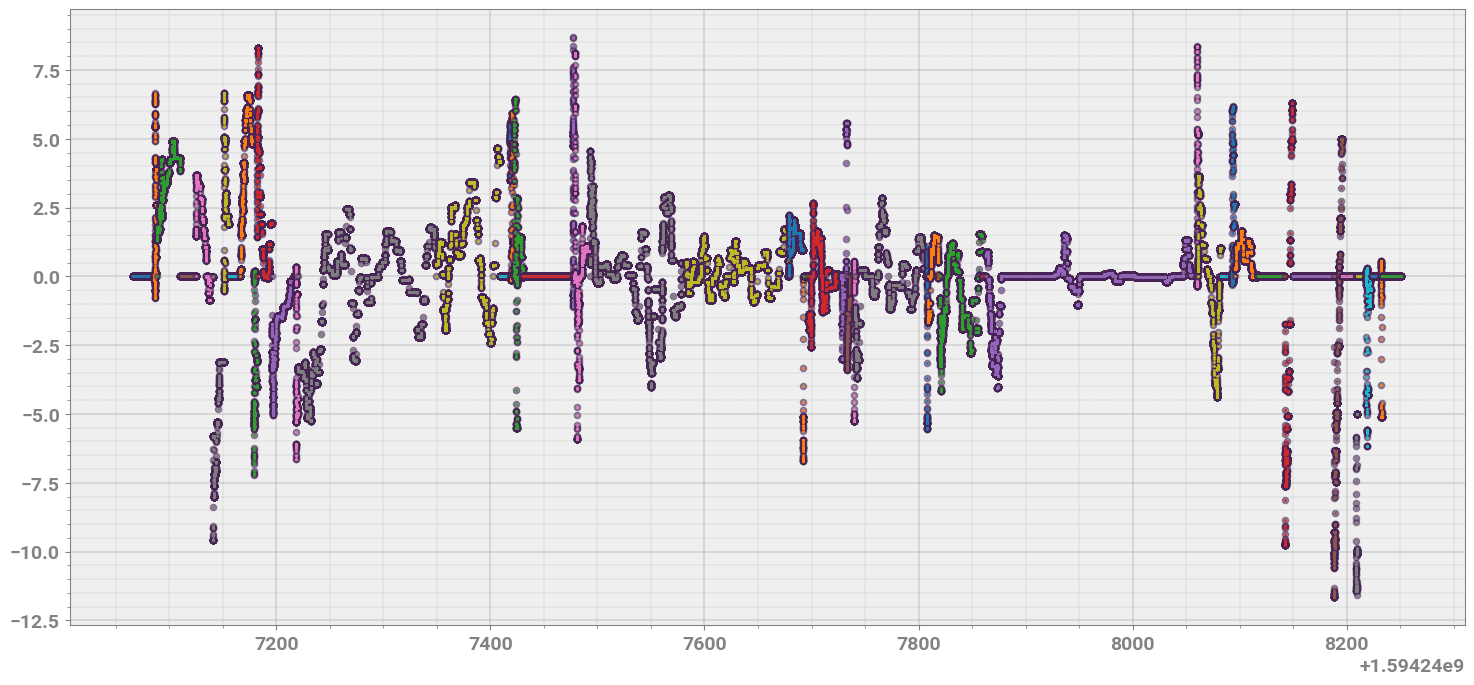

In [224]:
dflist = []
for m in lead_dist_l_chunks:
    lp = ml_differentiate(m, dense_time_points=True)
    dflist.append(lp)
    
fig, ax = strym.create_fig(1)
for po in dflist:
    ax[0].scatter(x = 'Time', y  = "Message", data = po, s = 20,marker = 'o', alpha = 0.5, color = "#462255")
    ax[0].scatter(x = 'Time', y  = "Message", data = po, s = 1)